In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import numpy as np
import matplotlib.pyplot as plt
from gensim.matutils import Sparse2Corpus


In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

from joblib import Parallel, delayed

In [14]:
# Load the data
file_path = "D:/Spotify/episodes_V5.csv"
data = pd.read_csv(file_path, index_col=False)

# Preview the data
print(data.head())


   Unnamed: 0.1  Unnamed: 0                 show_id  \
0             0        5482  4fRq8UFF7QAcea7xzqf5lg   
1             1        5483  4fRq8UFF7QAcea7xzqf5lg   
2             2        5484  4fRq8UFF7QAcea7xzqf5lg   
3             3        5485  4fRq8UFF7QAcea7xzqf5lg   
4             4        5486  4fRq8UFF7QAcea7xzqf5lg   

                                                name  \
0        How will GenAI Supercharge the XR Industry?   
1  Extracting the XR Value of Enterprise Tech Eve...   
2  How Virtual Reality is Shaping the Industrial ...   
3          Exploring African Enterprise XR Use Cases   
4  How to Leverage Today's Technology for AR/VR/M...   

                                         description release_date  \
0  XR Today’s Rory Greener speaks with Lenovo‘s H...   2024-11-26   
1  Watch on YouTube.In this episode of the Big XR...   2024-11-25   
2  XR Today's Rory Greener hosts Oliver Wohler, L...   2024-11-19   
3  XR Today's Rory Greener hosts Arome Ibrahim, P...   2

In [15]:
import re

def clean_text(text):
    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the function to the data column
data['preprocessed_description'] = data['cleaned_description'].apply(clean_text)


In [16]:
# Create a bag-of-words model
vectorizer = CountVectorizer(max_df=0.85, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(data['preprocessed_description'])

# Vocabulary
words = vectorizer.get_feature_names_out()

print(words)


['aa' 'aaa' 'aaaaand' ... 'zyon' 'zz' 'zzz']


In [21]:
# Parameters
batch_size = 10000  # Number of documents per batch
num_topics = 14  # Number of topics for LDA
passes = 10  # Number of passes for LDA

# Initialize dictionary and LDA model
dictionary = corpora.Dictionary([vectorizer.get_feature_names_out()])
lda_model = None

# Process data in batches
for start in range(0, dtm.shape[0], batch_size):
    # Extract the batch
    batch = dtm[start:start+batch_size]
    gensim_corpus = Sparse2Corpus(batch, documents_columns=False)
    
    # Train or update the LDA model
    if lda_model is None:
        # Initialize the model with the first batch
        lda_model = LdaModel(corpus=gensim_corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=passes)
    else:
        # Update the model with new batch data
        lda_model.update(gensim_corpus)

# Display topics
topics = lda_model.print_topics(num_topics=num_topics, num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")


Topic 0: 0.057*"football" + 0.050*"bama" + 0.048*"win" + 0.044*"tide" + 0.040*"wager" + 0.040*"restrictions" + 0.036*"guaranteed" + 0.031*"lockedoncollege" + 0.029*"nfl" + 0.028*"team"
Topic 1: 0.035*"miss" + 0.028*"available" + 0.027*"sec" + 0.023*"funny" + 0.022*"items" + 0.021*"love" + 0.020*"wheel" + 0.019*"enjoy" + 0.017*"laughter" + 0.017*"todays"
Topic 2: 0.059*"discord" + 0.056*"lying" + 0.028*"australia" + 0.027*"animated" + 0.025*"arnie" + 0.022*"spills" + 0.022*"adal" + 0.018*"rebel" + 0.017*"answered" + 0.016*"dynamic"
Topic 3: 0.042*"want" + 0.029*"right" + 0.026*"time" + 0.024*"like" + 0.022*"job" + 0.021*"youre" + 0.021*"need" + 0.020*"easy" + 0.018*"helps" + 0.018*"know"
Topic 4: 0.092*"money" + 0.042*"faster" + 0.041*"create" + 0.025*"business" + 0.025*"newsletter" + 0.015*"help" + 0.014*"make" + 0.014*"built" + 0.014*"strategies" + 0.013*"insights"
Topic 5: 0.307*"developer" + 0.051*"updates" + 0.036*"radio" + 0.031*"beat" + 0.027*"spoiler" + 0.021*"celebrity" + 0.021

In [22]:
lda_model.save("lda_model_14.gensim")


In [33]:
from gensim.models import LdaModel

lda_model = LdaModel.load("lda_model.gensim")


In [23]:
# Visualize topics
vis = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
# Render in notebook or save to an HTML file
pyLDAvis.display(vis)  # 在 Jupyter Notebook 中显示
pyLDAvis.save_html(vis, 'spotify_lda_topics_14.html')

print("LDA topic visualization saved as 'spotify_lda_topics_14.html'.")


LDA topic visualization saved as 'spotify_lda_topics_14.html'.


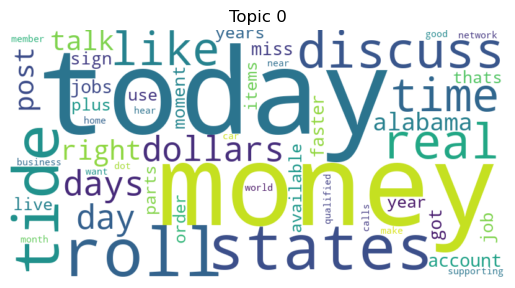

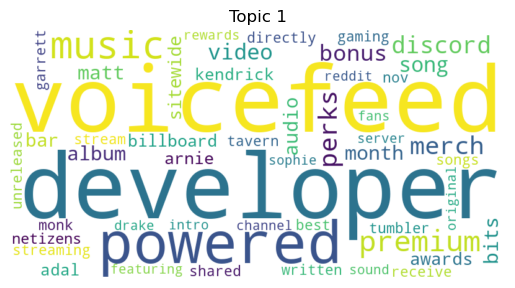

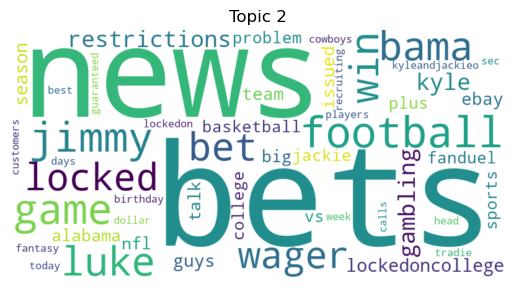

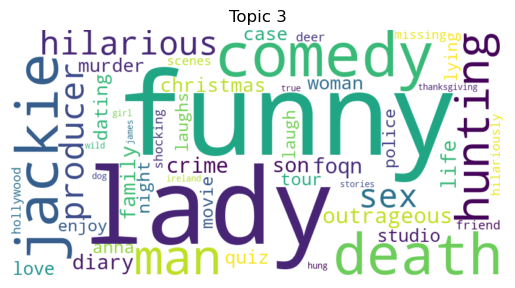

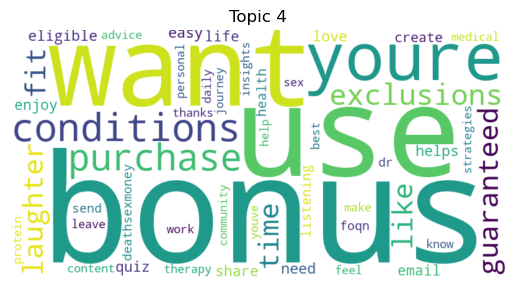

In [18]:
# Generate word clouds for each topic
for topic_id in range(num_topics):
    plt.figure()
    word_freq = dict(lda_model.show_topic(topic_id, topn=50))
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id}")
    plt.show()


In [28]:
# Get the topic distribution for a specific document
doc_id = 1
doc_topics = lda_model.get_document_topics(gensim_corpus[doc_id], minimum_probability=0.01)
doc_topics

[(0, 0.8207375),
 (1, 0.013565351),
 (2, 0.013738543),
 (3, 0.13860074),
 (4, 0.013357897)]

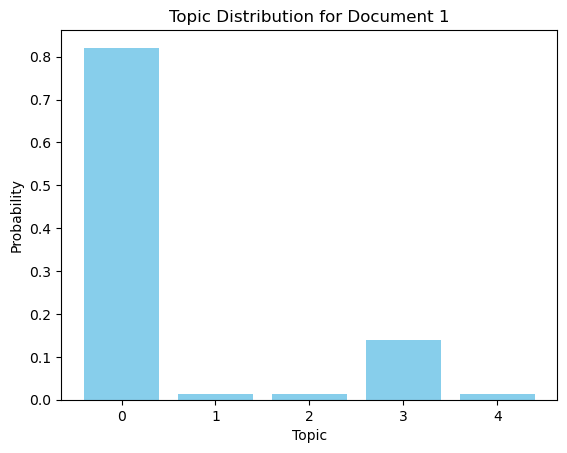

In [29]:
# Get the topic distribution for a specific document
doc_id = 1
doc_topics = lda_model.get_document_topics(gensim_corpus[doc_id], minimum_probability=0.01)

# Plot the topic distribution
topics, probabilities = zip(*doc_topics)
plt.bar(topics, probabilities, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title(f"Topic Distribution for Document {doc_id}")
plt.show()


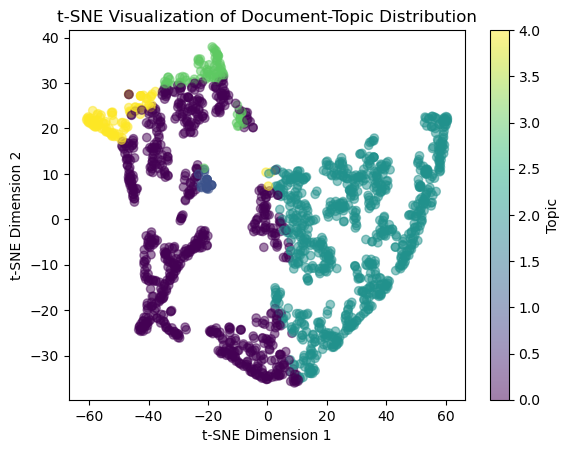

In [30]:
# Extract document-topic matrix
doc_topic_matrix = np.array([lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in gensim_corpus])
doc_topic_matrix = np.array([[prob for _, prob in doc] for doc in doc_topic_matrix])

# Perform TSNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(doc_topic_matrix)

# Plot the results
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5, c=np.argmax(doc_topic_matrix, axis=1), cmap='viridis')
plt.colorbar(label='Topic')
plt.title('t-SNE Visualization of Document-Topic Distribution')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


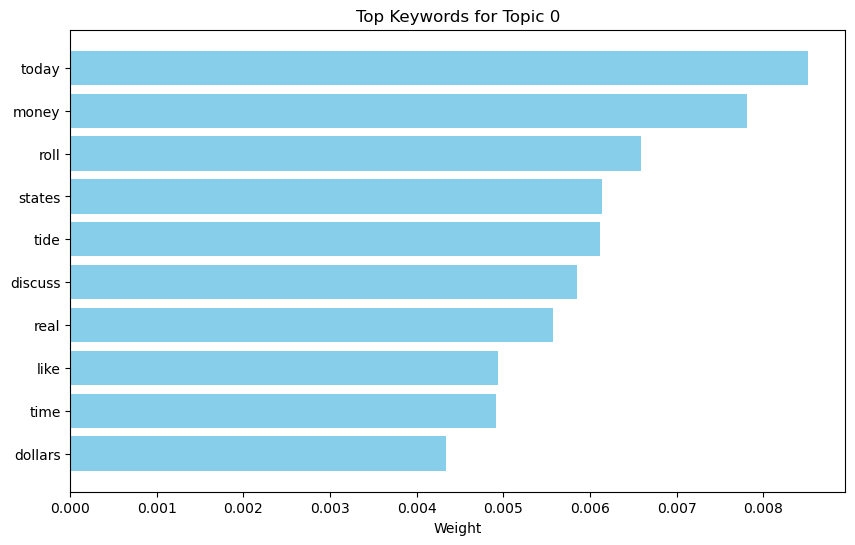

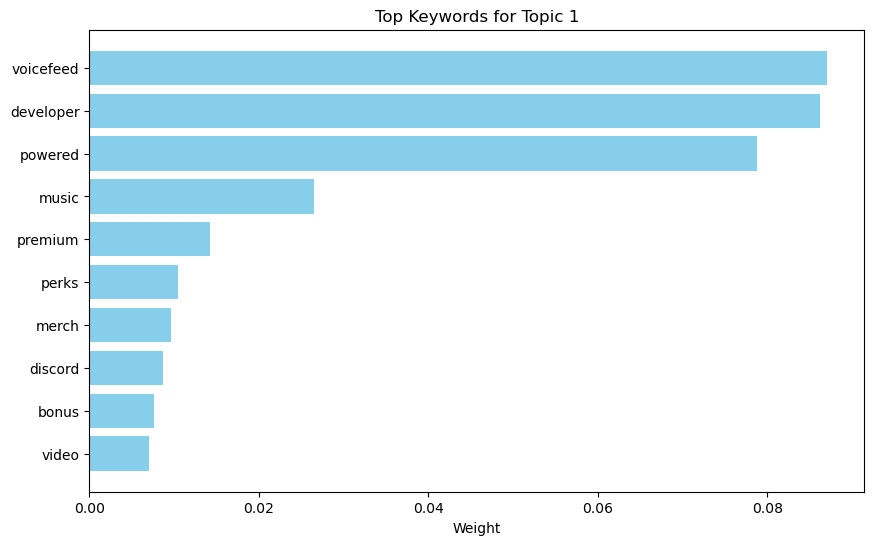

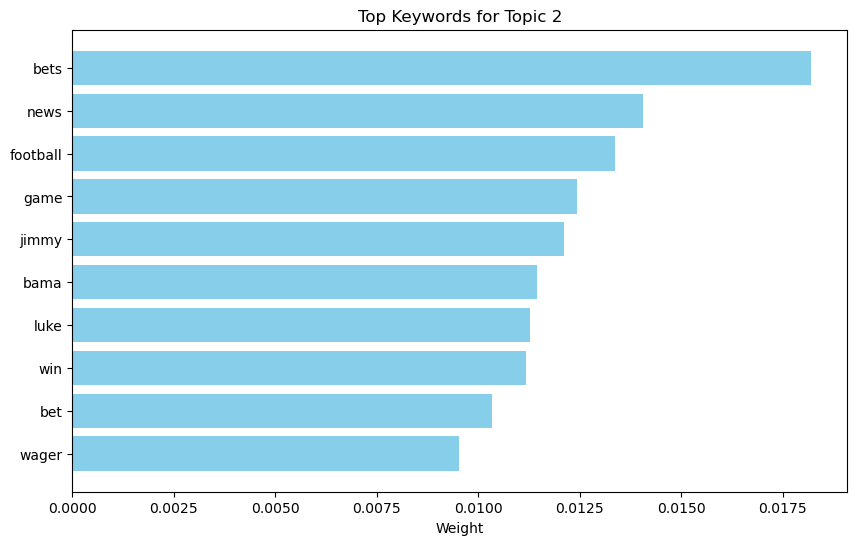

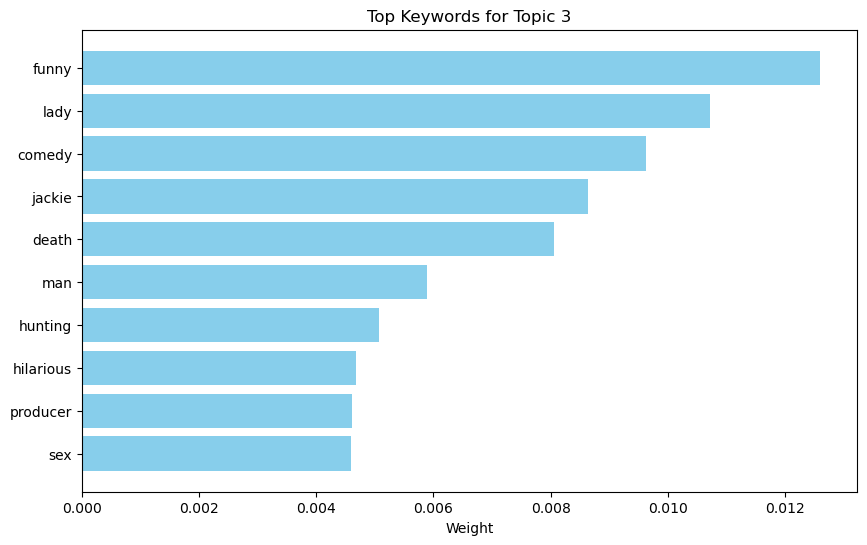

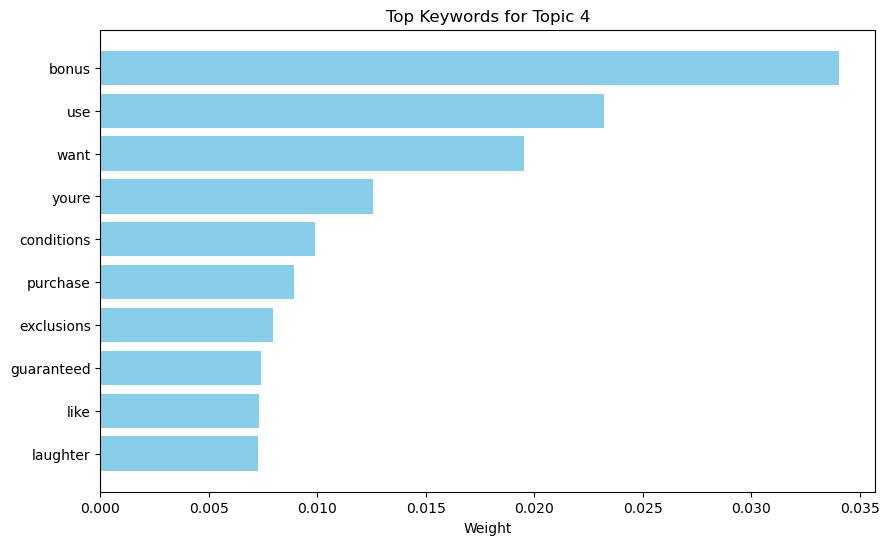

In [31]:
for topic_id in range(num_topics):
    plt.figure(figsize=(10, 6))
    topic = lda_model.show_topic(topic_id, topn=10)
    words, weights = zip(*topic)
    plt.barh(words, weights, color='skyblue')
    plt.xlabel('Weight')
    plt.title(f'Top Keywords for Topic {topic_id}')
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract document-topic matrix
doc_topic_matrix = np.array([[prob for _, prob in lda_model.get_document_topics(doc, minimum_probability=0.0)] for doc in gensim_corpus])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(doc_topic_matrix, cmap="YlGnBu", cbar=True)
plt.xlabel('Topic')
plt.ylabel('Document')
plt.title('Document-Topic Heatmap')
plt.show()


In [ ]:
# Extract topic-word matrix
topic_word_matrix = lda_model.get_topics()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_word_matrix, cmap="YlGnBu", cbar=True)
plt.xlabel('Words')
plt.ylabel('Topics')
plt.title('Topic-Word Heatmap')
plt.show()


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
vis = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary)

# Display the visualization
pyLDAvis.display(vis)


In [ ]:
from math import pi

# Select a document
doc_id = 1
doc_topics = lda_model.get_document_topics(gensim_corpus[doc_id], minimum_probability=0.01)

# Data preparation for radar plot
topics, probabilities = zip(*doc_topics)
categories = [f'Topic {t}' for t in topics]
values = list(probabilities)
values += values[:1]  # Repeat the first value to close the circle

# Radar plot
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.4)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticks([0.1, 0.2, 0.3])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title(f"Topic Distribution for Document {doc_id}")
plt.show()


In [ ]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_id in range(num_topics):
    plt.figure(figsize=(8, 6))
    topic = lda_model.show_topic(topic_id, topn=50)
    topic_dict = {word: weight for word, weight in topic}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_dict)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(doc_topic_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8.)
plt.title("Hierarchical Clustering of Documents based on Topics")
plt.xlabel("Document Index")
plt.ylabel("Distance")
plt.show()


In [38]:
podcast_data = data

# Tokenize the 'cleaned_description' column
podcast_data['tokens'] = podcast_data['preprocessed_description'].apply(lambda x: x.split())

# Use the existing dictionary from lda_model (avoid rebuilding the dictionary)
dictionary = lda_model.id2word

# Convert tokens into a corpus that matches the existing model's dictionary
corpus = [dictionary.doc2bow(text) for text in podcast_data['tokens']]

# Function to extract topic distributions for each document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc in corpus:
        # Get the topic distribution for each document from the existing lda_model
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        # Convert the topic distribution into a fixed-length vector
        topic_probs = [prob for _, prob in sorted(topics, key=lambda x: x[0])]
        topic_distributions.append(topic_probs)
    return topic_distributions

# Get the topic distributions and convert them into a DataFrame
topic_distributions = get_topic_distribution(lda_model, corpus)
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic{i}" for i in range(lda_model.num_topics)])

# Append the topic distributions to the original dataset
podcast_data = pd.concat([podcast_data, topic_df], axis=1)


In [39]:
print(podcast_data.head(10))

   Unnamed: 0                 show_id  \
0           0  4fRq8UFF7QAcea7xzqf5lg   
1           1  4fRq8UFF7QAcea7xzqf5lg   
2           2  4fRq8UFF7QAcea7xzqf5lg   
3           3  4fRq8UFF7QAcea7xzqf5lg   
4           4  4fRq8UFF7QAcea7xzqf5lg   
5           5  4fRq8UFF7QAcea7xzqf5lg   
6           6  4fRq8UFF7QAcea7xzqf5lg   
7           7  4fRq8UFF7QAcea7xzqf5lg   
8           8  4fRq8UFF7QAcea7xzqf5lg   
9           9  4fRq8UFF7QAcea7xzqf5lg   

                                                name  \
0        How will GenAI Supercharge the XR Industry?   
1  Extracting the XR Value of Enterprise Tech Eve...   
2  How Virtual Reality is Shaping the Industrial ...   
3          Exploring African Enterprise XR Use Cases   
4  How to Leverage Today's Technology for AR/VR/M...   
5      UK MR Headset Vendor Acquired for $45 Million   
6  Virtualware Debuts VIROO 2.6: Ready-to-run XR ...   
7  Big XR News: Microsoft Leave Headset Race, Ori...   
8  Big XR News: XR Leaders Analyse Meta Conn

In [40]:
output_path = "spotify_podcasts_topic.csv"
podcast_data.to_csv(output_path, index=False)
print(f"Data has been saved to {output_path}")

Data has been saved to spotify_podcasts_topic.csv


In [ ]:
# Ensure necessary topic columns
topic_columns = [col for col in podcast_data.columns if "Topic" in col]

# Define a function to find the nearest podcast for each row
def find_nearest_podcast(metrics_df, topic_columns):
    nearest_ids = []
    nearest_names = []

    for idx, row in metrics_df.iterrows():
        # Get the current row's topic vector
        current_vector = row[topic_columns].values.reshape(1, -1)
        
        # Compute cosine similarity with all other rows
        other_vectors = metrics_df[topic_columns].values
        similarity_scores = cosine_similarity(current_vector, other_vectors).flatten()
        
        # Exclude itself and find the most similar podcast
        similarity_scores[idx] = -1  # Set its own similarity to -1 to exclude
        nearest_idx = similarity_scores.argmax()  # Find the index of the nearest neighbor
        
        # Append the nearest podcast's ID and name
        nearest_ids.append(metrics_df.iloc[nearest_idx]["id"])
        nearest_names.append(metrics_df.iloc[nearest_idx]["name"])

    # Add results to the DataFrame
    metrics_df["nearest_podcast_id"] = nearest_ids
    metrics_df["nearest_podcast_name"] = nearest_names
    
    return metrics_df

# Apply the function to find nearest podcasts
podcast_data_with_nearest = find_nearest_podcast(podcast_data, topic_columns)

# Save the updated DataFrame to a CSV file
output_path = "spotify_podcast_with_nearest.csv"
podcast_data_with_nearest.to_csv(output_path, index=False)

# Display results
podcast_data_with_nearest[["id", "name", "nearest_podcast_id", "nearest_podcast_name"]].head(), output_path


In [4]:
# Load the data
file_path = "spotify_podcast_with_nearest.csv"
podcast_data_with_nearest = pd.read_csv(file_path, index_col=False)

# Preview the data
print(podcast_data_with_nearest.head())

   Unnamed: 0                 show_id  \
0           0  4fRq8UFF7QAcea7xzqf5lg   
1           1  4fRq8UFF7QAcea7xzqf5lg   
2           2  4fRq8UFF7QAcea7xzqf5lg   
3           3  4fRq8UFF7QAcea7xzqf5lg   
4           4  4fRq8UFF7QAcea7xzqf5lg   

                                                name  \
0        How will GenAI Supercharge the XR Industry?   
1  Extracting the XR Value of Enterprise Tech Eve...   
2  How Virtual Reality is Shaping the Industrial ...   
3          Exploring African Enterprise XR Use Cases   
4  How to Leverage Today's Technology for AR/VR/M...   

                                         description                      id  \
0  XR Today’s Rory Greener speaks with Lenovo‘s H...  52zyWZO33bvkURglMYUsOD   
1  Watch on YouTube.In this episode of the Big XR...  7M8Rzr9sFSpnxOm934zdNE   
2  XR Today's Rory Greener hosts Oliver Wohler, L...  4YvtBECQkIfwfuWDQl6WOA   
3  XR Today's Rory Greener hosts Arome Ibrahim, P...  4rRvARzNOwG2UT59ABb4Ne   
4  Watch on YouT

In [6]:
# Ensure necessary topic columns
topic_columns = [col for col in podcast_data_with_nearest.columns if "Topic" in col]
# Add a similarity check for each nearest podcast
def check_nearest_similarity(metrics_df, topic_columns):
    similarities = []
    
    for idx, row in metrics_df.iterrows():
        # Get the current podcast's vector
        current_vector = row[topic_columns].values.reshape(1, -1)
        
        # Get the nearest podcast's index
        nearest_idx = metrics_df[metrics_df["id"] == row["nearest_podcast_id"]].index[0]
        nearest_vector = metrics_df.iloc[nearest_idx][topic_columns].values.reshape(1, -1)
        
        # Compute the cosine similarity
        similarity = cosine_similarity(current_vector, nearest_vector)[0, 0]
        similarities.append(similarity)
    
    # Add similarity scores to the DataFrame
    metrics_df["nearest_similarity"] = similarities
    return metrics_df

# Add similarity scores to the DataFrame
podcast_data_with_nearest = check_nearest_similarity(podcast_data_with_nearest, topic_columns)

# Display the nearest podcasts with similarity scores
podcast_data_with_nearest[["id", "name", "nearest_podcast_id", "nearest_podcast_name", "nearest_similarity"]].head()


,id,name,nearest_podcast_id,nearest_podcast_name,nearest_similarity
0,52zyWZO33bvkURglMYUsOD,How will GenAI Supercharge the XR Industry?,5tmsFGydv2BYxtvDnkZDRa,The B2B Pipeline - SaaS Go-to-Market Strategy ...,0.999999
1,7M8Rzr9sFSpnxOm934zdNE,Extracting the XR Value of Enterprise Tech Eve...,4JzonWpwcaEhtG3izQcQHK,"Swiatek's Suspension, Sinner's Court Date, & J...",0.999982
2,4YvtBECQkIfwfuWDQl6WOA,How Virtual Reality is Shaping the Industrial ...,1nnDXvhBVZcrupgotoB14T,"U.S. Stocks Rise as Investors Eye Ukraine, Int...",0.999994
3,4rRvARzNOwG2UT59ABb4Ne,Exploring African Enterprise XR Use Cases,273esRLGZI3UkWetUcBCLT,Cosmopolitan Magazine’s List Of Things That Tu...,0.999999
4,7w23I1lpZFgIQTEcncoFYI,How to Leverage Today's Technology for AR/VR/M...,4bTFXBMLhdiu1MyI0K7WdP,[Uninterrupted] EPIC WARNING- Fmr. GOP Operati...,1.000000


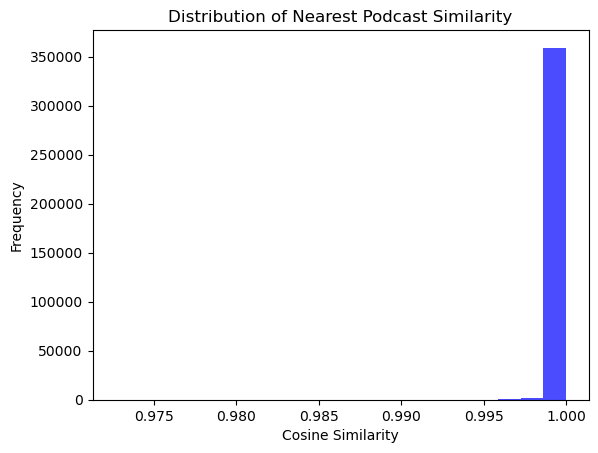

In [8]:
# Plot the similarity distribution
plt.hist(podcast_data_with_nearest["nearest_similarity"], bins=20, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Nearest Podcast Similarity")
plt.show()
